In [51]:
import pandas as pd
import numpy as np
import random
import ray
from itertools import combinations
import torch.nn as nn
import torch
import math
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')
from sklearn.decomposition import PCA
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [2]:
seed = 42
np.random.seed(seed)
random.seed(seed)

In [3]:
####################################
## cathub
####################################

In [3]:
df_cat1 = pd.read_pickle('datasets/reactions_info_df.pickle')

list_scols = ['s' + str(i) for i in range(9)]
list_pcols = ['p' + str(i) for i in range(768)]
list_cols = ['sc', 'facet'] + list_scols + list_pcols + ['nre']
df_cat1 = df_cat1[list_cols]

df_cat1.shape

df_cat1.head(2)

unique_groups_df_cat1 = df_cat1[['sc', 'facet']].drop_duplicates()
num_unique_groups_df_cat1 = unique_groups_df_cat1.shape[0]
print(f"Number of distinct groups for ['sc', 'facet'] in df_cat1: {num_unique_groups_df_cat1}")

In [9]:
####################################
## ocp
####################################

In [10]:
df_ocp1 = pd.read_parquet('datasets/ocp_reactions_info_df.parquet')

df_ocp1.head(2)

def convert_to_int(x):
    try:
        return str(''.join(map(str, x)))
    except ValueError:
        print(f"Error with value: {x}")
        return x
    
df_ocp1.rename(columns={'energy': 'nre'}, inplace=True)
df_ocp1['miller_index'] = df_ocp1['miller_index'].apply(convert_to_int)
list_scols = ['s' + str(i) for i in range(9)]
list_pcols = ['p' + str(i) for i in range(768)]
list_cols = ['bulk_mpid', 'miller_index'] + list_scols + list_pcols + ['nre']
df_ocp1 = df_ocp1[list_cols]

df_ocp1.shape

df_ocp1.head(2)

unique_groups_df_ocp1 = df_ocp1[['bulk_mpid', 'miller_index']].drop_duplicates()
num_unique_groups_df_ocp1 = unique_groups_df_ocp1.shape[0]
print(f"Number of distinct groups for ['bulk_mpid', 'miller_index'] in df_ocp1: {num_unique_groups_df_ocp1}")

In [16]:
####################################
## env creation
####################################

In [17]:
## do: create env for cathub

df = df_cat1

# Create a new 'group' column in df that combines 'sc' and 'facet' 
df['group'] = list(zip(df['sc'], df['facet']))

# Find distinct groups and calculate the number of train/test groups
distinct_values_df = df[['group']].drop_duplicates().reset_index(drop=True)
list_env_group = [tuple(x) for x in distinct_values_df['group'].values]
n_env_total = len(list_env_group)
n_env_train = int(0.75 * n_env_total) # Update when necessary
train_env_groups = set(random.sample(list_env_group, n_env_train))
test_env_groups = set(list_env_group) - train_env_groups

# Create list of dataframes for each training group
list_env_train_cat1 = [df[df['group'] == grp].reset_index(drop=True) for grp in train_env_groups]

# Concatenate the list to form a single dataframe for the training set
df_train_cat1 = pd.concat(list_env_train_cat1, ignore_index=True)

# Get all the rows that don't belong to the training set groups
mask_train = df['group'].isin(train_env_groups)
df_test_cat1 = df[~mask_train].reset_index(drop=True)

# Cleanup: Drop the 'group' column as it's no longer needed
df.drop(columns=['group'], inplace=True)
df_train_cat1.drop(columns=['group'], inplace=True)
df_test_cat1.drop(columns=['group'], inplace=True)

print(len(list_env_train_cat1), len(train_env_groups), len(test_env_groups), n_env_total)
print(df_train_cat1.shape, df_test_cat1.shape, df.shape)

# Check the distinct groups
distinct_groups_train = df_train_cat1[['sc', 'facet']].drop_duplicates().reset_index(drop=True)
distinct_groups_test = df_test_cat1[['sc', 'facet']].drop_duplicates().reset_index(drop=True)
print(len(distinct_groups_train), len(distinct_groups_test))

1437 1437 479 1916
(8483, 780) (2774, 780) (11257, 780)
1437 479


In [18]:
## do: create env for ocp

df = df_ocp1

# Create a new 'group' column in df that combines 'bulk_mpid' and 'miller_index' 
df['group'] = list(zip(df['bulk_mpid'], df['miller_index']))

# Find distinct groups and calculate the number of train/test groups
distinct_values_df = df[['group']].drop_duplicates().reset_index(drop=True)
list_env_group = [tuple(x) for x in distinct_values_df['group'].values]
n_env_total = len(list_env_group)
# n_env_train = int(0.75 * n_env_total) # Update when necessary
train_env_groups = set(random.sample(list_env_group, n_env_train))
test_env_groups = set(list_env_group) - train_env_groups

# Create list of dataframes for each training group
list_env_train_ocp1 = [df[df['group'] == grp].reset_index(drop=True) for grp in train_env_groups]

# Concatenate the list to form a single dataframe for the training set
df_train_ocp1 = pd.concat(list_env_train_ocp1, ignore_index=True)

# Get all the rows that don't belong to the training set groups
mask_train = df['group'].isin(train_env_groups)
df_test_ocp1 = df[~mask_train].reset_index(drop=True)

# Cleanup: Drop the 'group' column as it's no longer needed
df.drop(columns=['group'], inplace=True)
df_train_ocp1.drop(columns=['group'], inplace=True)
df_test_ocp1.drop(columns=['group'], inplace=True)

print(len(list_env_train_ocp1), len(train_env_groups), len(test_env_groups), n_env_total)
print(df_train_ocp1.shape, df_test_ocp1.shape, df.shape)

# Check the distinct groups
distinct_groups_train = df_train_ocp1[['bulk_mpid', 'miller_index']].drop_duplicates().reset_index(drop=True)
distinct_groups_test = df_test_ocp1[['bulk_mpid', 'miller_index']].drop_duplicates().reset_index(drop=True)
print(len(distinct_groups_train), len(distinct_groups_test))

1437 1437 89861 91298
(6665, 780) (431116, 780) (437781, 780)
1437 89861


In [19]:
#############################################################################
## experiment with (cathub, ocp) X (ridge, elastic, krr, svr) X (org, pca, siamese) 
#############################################################################

In [20]:
## do: (cathub) x (ridge, elastic, krr, svr) x (pca)

In [21]:
df_train_cat1.shape, df_test_cat1.shape

((8483, 780), (2774, 780))

In [22]:
df_train_cat1.head(2)

,sc,facet,s0,s1,s2,s3,s4,s5,s6,s7,...,p759,p760,p761,p762,p763,p764,p765,p766,p767,nre
0,Ti3Y,111,0.362952,-0.457782,-0.212769,-0.591562,0.151697,-0.472479,-0.5328,0.267401,...,1.128245,0.940684,1.901682,-0.801239,-1.315113,-0.644158,0.311038,-0.162647,-0.846766,0.496234
1,Ti3Y,111,0.362952,-0.457782,-0.212769,-0.591562,0.151697,-0.472479,-0.5328,0.267401,...,0.718674,1.495406,1.609272,-2.305226,0.098274,-1.220422,0.434692,-0.222176,-0.489837,-0.959664


In [23]:
df_test_cat1.head(2)

,sc,facet,s0,s1,s2,s3,s4,s5,s6,s7,...,p759,p760,p761,p762,p763,p764,p765,p766,p767,nre
0,AgIn,101,1.135173,1.329863,1.899129,2.254967,2.122824,2.132296,2.03885,0.490853,...,1.128245,0.940684,1.901682,-0.801239,-1.315113,-0.644158,0.311038,-0.162647,-0.846766,4.625719
1,AgIn,101,1.135173,1.329863,1.899129,2.254967,2.122824,2.132296,2.03885,0.490853,...,0.718674,1.495406,1.609272,-2.305226,0.098274,-1.220422,0.434692,-0.222176,-0.489837,0.658772


In [24]:
# Separate features and targets
X_train = df_train_cat1.iloc[:, 2:-1]
y_train = df_train_cat1.iloc[:, -1]
X_test = df_test_cat1.iloc[:, 2:-1]
y_test = df_test_cat1.iloc[:, -1]

In [24]:
# Standardize the features
scaler_X = StandardScaler().fit(X_train)
X_train_std = scaler_X.transform(X_train)
X_test_std = scaler_X.transform(X_test)

In [24]:
# Apply PCA and retain 90% variance
pca = PCA(n_components=0.9)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)
print(X_train_pca.shape)

In [27]:
# Models and hyperparameters
models = {
    'Ridge Regression': {
        'model': Ridge(),
        'params': {
            'alpha': [0.1, 1, 10]
        }
    },
    'Elastic Regression': {
        'model': ElasticNet(),
        'params': {
            'alpha': [0.1, 1, 10],
            'l1_ratio': [0.3, 0.5, 0.7]
        }
    },
    'Kernel Ridge Regression': {
        'model': KernelRidge(),
        'params': {
            'alpha': [0.1, 1, 10],
            'kernel': ['linear', 'polynomial', 'rbf'],
            'degree': [2, 3, 4]
        }
    },
    'Support Vector Regression': {
        'model': SVR(),
        'params': {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf'],
            'gamma': ['auto', 'scale']
        }
    }
}

In [28]:
# Display mean absolute value of the target
mean_absolute_target = y_test.abs().mean()
print(f"Mean Absolute Value of Target: {mean_absolute_target}")

Mean Absolute Value of Target: 1.7792317309954568


Ridge Regression Mean Absolute Error with Best Hyperparameters: 1.003859358243083


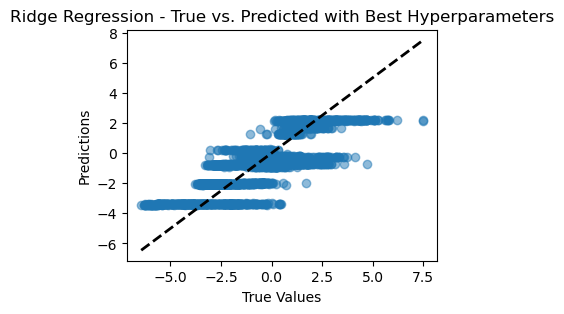

Elastic Regression Mean Absolute Error with Best Hyperparameters: 1.002037699128813


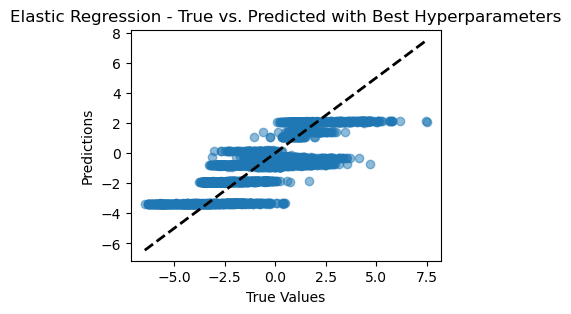

Kernel Ridge Regression Mean Absolute Error with Best Hyperparameters: 0.4175666456003047


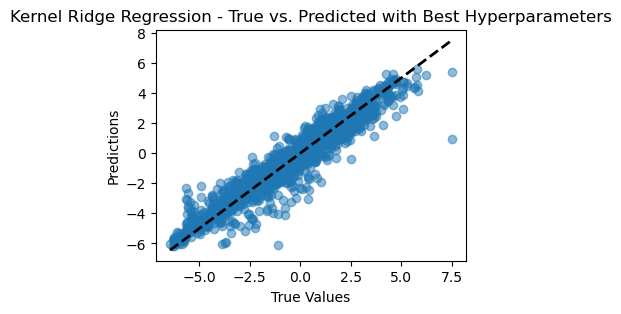

Support Vector Regression Mean Absolute Error with Best Hyperparameters: 0.44518854057793195


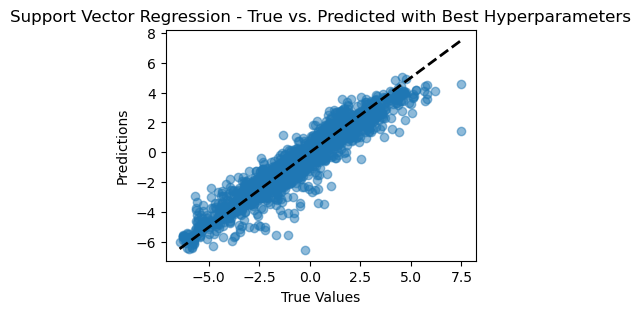

In [29]:
# Tune hyperparameters and train models
for name, model_info in models.items():
    grid_search = GridSearchCV(model_info['model'], model_info['params'], scoring='neg_mean_absolute_error', cv=5)
    grid_search.fit(X_train_pca, y_train)
    
    # Use the best model for predictions
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_pca)
    
    # Mean Absolute Error
    mae = mean_absolute_error(y_test, y_pred)
    print(f"{name} Mean Absolute Error with Best Hyperparameters: {mae}")
    
    # Plot true vs. predicted values
    plt.figure(figsize=(4, 3))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel("True Values")
    plt.ylabel("Predictions")
    plt.title(f"{name} - True vs. Predicted with Best Hyperparameters")
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.show()

In [30]:
## do: (ocp) x (ridge, elastic, krr, svr) x (pca)

In [31]:
df_train_ocp1.shape, df_test_ocp1.shape

((6665, 780), (431116, 780))

In [32]:
df_train_ocp1.head(2)

,bulk_mpid,miller_index,s0,s1,s2,s3,s4,s5,s6,s7,...,p759,p760,p761,p762,p763,p764,p765,p766,p767,nre
0,mp-11549,012,0.112835,-0.004902,-0.003539,-2.328094,1.468344,-0.451233,-3.723246,-0.444849,...,-0.342597,0.688204,0.952127,-1.155227,-1.193798,-0.609899,0.123323,-1.217244,-0.322334,-5.552895
1,mp-11549,012,0.112835,-0.004902,-0.003539,-2.328094,1.468344,-0.451233,-3.723246,-0.444849,...,-0.373280,0.889269,0.656399,-0.886621,-1.203259,-1.252966,-0.106142,-0.521200,-0.224356,-4.684858


In [33]:
df_test_ocp1.head(2)

,bulk_mpid,miller_index,s0,s1,s2,s3,s4,s5,s6,s7,...,p759,p760,p761,p762,p763,p764,p765,p766,p767,nre
0,mp-976273,210,0.008258,1.035261,1.294881,1.552592,1.783934,1.012493,2.079694,0.436319,...,0.273536,0.742442,0.618160,0.486411,-0.934350,0.204278,0.679431,0.341144,-0.852883,-9.992999
1,mp-1247259,100,0.005488,0.162778,0.328713,1.856944,1.908573,1.835093,1.429667,0.374538,...,-0.456795,0.304594,1.134157,-0.394405,-1.171003,-0.648138,-0.021550,-1.443121,0.004959,-9.982733


In [34]:
# Separate features and targets
X_train = df_train_ocp1.iloc[:, 2:-1]
y_train = df_train_ocp1.iloc[:, -1]
X_test = df_test_ocp1.iloc[:, 2:-1]
y_test = df_test_ocp1.iloc[:, -1]

In [35]:
# Standardize the features
scaler_X = StandardScaler().fit(X_train)
X_train_std = scaler_X.transform(X_train)
X_test_std = scaler_X.transform(X_test)

In [36]:
# Apply PCA and retain 90% variance
pca = PCA(n_components=0.9)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)
print(X_train_pca.shape)

(6665, 17)


In [37]:
# Models and hyperparameters
models = {
    'Ridge Regression': {
        'model': Ridge(),
        'params': {
            'alpha': [0.1, 1, 10]
        }
    },
    'Elastic Regression': {
        'model': ElasticNet(),
        'params': {
            'alpha': [0.1, 1, 10],
            'l1_ratio': [0.3, 0.5, 0.7]
        }
    },
    'Kernel Ridge Regression': {
        'model': KernelRidge(),
        'params': {
            'alpha': [0.1, 1, 10],
            'kernel': ['linear', 'polynomial', 'rbf'],
            'degree': [2, 3, 4]
        }
    },
    'Support Vector Regression': {
        'model': SVR(),
        'params': {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf'],
            'gamma': ['auto', 'scale']
        }
    }
}

In [38]:
# Display mean absolute value of the target
mean_absolute_target = y_test.abs().mean()
print(f"Mean Absolute Value of Target: {mean_absolute_target}")

Mean Absolute Value of Target: 2.2792969100635108


Ridge Regression Mean Absolute Error with Best Hyperparameters: 20586.813623171016


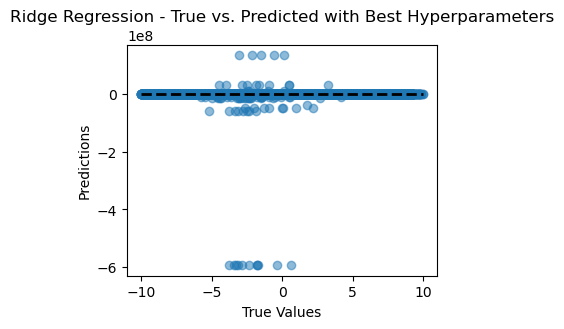

Elastic Regression Mean Absolute Error with Best Hyperparameters: 20193.30482733301


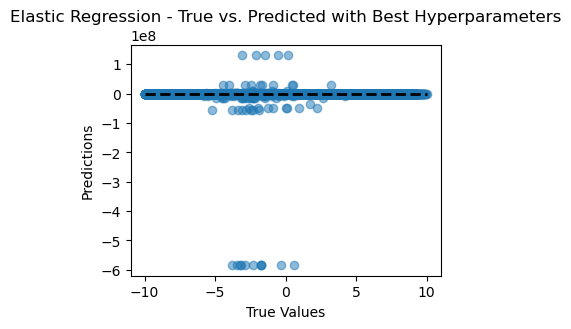

Kernel Ridge Regression Mean Absolute Error with Best Hyperparameters: 1.2549156079467678


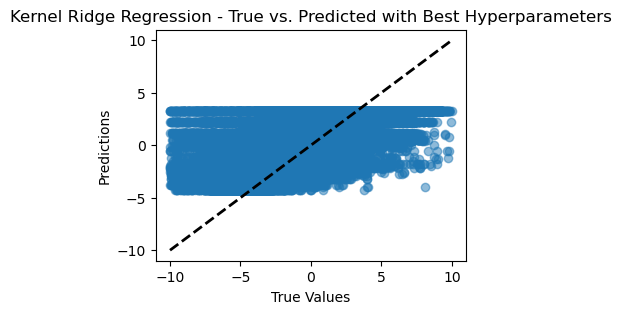

Support Vector Regression Mean Absolute Error with Best Hyperparameters: 1.2438680722655857


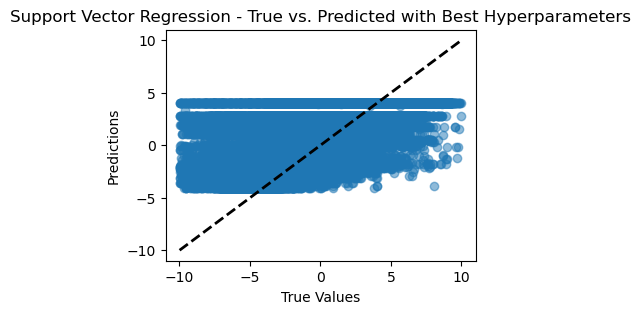

In [39]:
# Tune hyperparameters and train models
for name, model_info in models.items():
    grid_search = GridSearchCV(model_info['model'], model_info['params'], scoring='neg_mean_absolute_error', cv=5)
    grid_search.fit(X_train_pca, y_train)
    
    # Use the best model for predictions
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_pca)
    
    # Mean Absolute Error
    mae = mean_absolute_error(y_test, y_pred)
    print(f"{name} Mean Absolute Error with Best Hyperparameters: {mae}")
    
    # Plot true vs. predicted values
    plt.figure(figsize=(4, 3))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel("True Values")
    plt.ylabel("Predictions")
    plt.title(f"{name} - True vs. Predicted with Best Hyperparameters")
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.show()

In [52]:
## do: (cathub) x (ridge, elastic, krr, svr) x (siamese)

In [53]:
def create_comparison_data(df):
    n_samples = df.shape[0]
    feature_data = []
    target_data = []
    
    for i in range(n_samples):
        for j in range(i+1, n_samples):
            sample_i = df.iloc[i, 2:779].values
            sample_j = df.iloc[j, 2:779].values
            difference = df.iloc[i, 779] - df.iloc[j, 779]
            
            combined_features = np.concatenate([sample_i, sample_j])
            
            feature_data.append(combined_features)
            target_data.append(difference)
    
    return feature_data, target_data

In [54]:
class SiameseNetwork(torch.nn.Module):
    def __init__(self, len_embedding, abstract_len_embedding, n_hidden_node=32):
        super(SiameseNetwork, self).__init__()
        self.loss = nn.L1Loss(reduction="mean") 
        self.len_embedding = len_embedding
        self.abstract_len_embedding = abstract_len_embedding  
        self.n_hidden_node = n_hidden_node
        self.nn_reg = nn.Sequential(
            nn.Linear(self.len_embedding, self.abstract_len_embedding),
        )
        self.nn_final_reg = nn.Sequential(
            nn.Linear(self.abstract_len_embedding * 2, self.n_hidden_node),nn.ReLU(inplace=True),nn.BatchNorm1d(self.n_hidden_node),nn.Dropout(p=0.2),
            nn.Linear(self.n_hidden_node, int(self.n_hidden_node/4)),nn.ReLU(inplace=True),nn.BatchNorm1d(int(self.n_hidden_node/4)),nn.Dropout(p=0.2),
            nn.Linear(int(self.n_hidden_node/4), 1),
        )

    def forward_reg(self, x):
        output = self.nn_reg(x)
        return output

    def forward_final_reg(self, x):
        output = self.nn_final_reg(x)
        return output

    def forward(self, fp1, fp2):
        a = self.forward_reg(fp1)
        b = self.forward_reg(fp2)
        x = torch.cat([a, b], dim=1)  # hstack
        output = self.forward_final_reg(x)
        return output

In [55]:
# Combine both lists of DataFrames
all_dfs = list_env_train_cat1 + list_env_train_ocp1

# Initialize empty lists for all feature data and target data
all_feature_data = []
all_target_data = []

# Iterate over the combined list of DataFrames and create comparison data
for dataframe in all_dfs:
    feature_data, target_data = create_comparison_data(dataframe)
    all_feature_data.extend(feature_data)
    all_target_data.extend(target_data)

# Convert lists to arrays
X = np.array(all_feature_data)
y = np.array(all_target_data)

print(X.shape, y.shape)

(56377, 1554) (56377,)


In [56]:
# 1. Standardize the Data
scaler = StandardScaler().fit(X)
X_std = scaler.transform(X)

In [58]:
# 2. Split the Data into `fp1` and `fp2`
fp1 = torch.tensor(X_std[:, :777], dtype=torch.float32)
fp2 = torch.tensor(X_std[:, 777:], dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)  # Convert y to tensor and add a dimension

In [59]:
# Create DataLoader for batch processing
dataset = TensorDataset(fp1, fp2, y_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [61]:
# 3. Define Hyperparameters for Grid Search
n_hidden_nodes = [8]
learning_rates = [0.01]
num_epochs = 100  # Adjust as necessary

In [63]:
# 4. Train Siamese Network with Each Hyperparameter Combination

best_model = None
lowest_error = float('inf')

for n_hidden_node in n_hidden_nodes:
    for lr in learning_rates:
        
        model = SiameseNetwork(777, 6, n_hidden_node)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        
        for epoch in range(num_epochs):
            print(epoch)
            for batch_fp1, batch_fp2, batch_y in dataloader:
                optimizer.zero_grad()
                outputs = model(batch_fp1, batch_fp2)
                loss = model.loss(outputs, batch_y)
                loss.backward()
                optimizer.step()
        
        # Calculate training error for the current hyperparameter combination
        with torch.no_grad():
            all_outputs = model(fp1, fp2)
            train_error = model.loss(all_outputs, y_tensor).item()
        
        # Update best model and lowest error if needed
        if train_error < lowest_error:
            lowest_error = train_error
            best_model = model

print(f"Best Model has a training error of: {lowest_error}")

In [84]:
df_train_cat1.shape, df_test_cat1.shape

In [84]:
df_train_cat1.head(2)

In [84]:
df_test_cat1.head(2)

In [84]:
# Separate features and targets
X_train = df_train_cat1.iloc[:, 2:-1]
y_train = df_train_cat1.iloc[:, -1]
X_test = df_test_cat1.iloc[:, 2:-1]
y_test = df_test_cat1.iloc[:, -1]

In [84]:
# Standardize the features
scaler_X = StandardScaler().fit(X_train)
X_train_std = scaler_X.transform(X_train)
X_test_std = scaler_X.transform(X_test)

In [84]:
X_train_tensor = torch.tensor(X_train_std, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_std, dtype=torch.float32)

In [84]:
# Use the model to transform the data
X_train_siamese_tensor = best_model.nn_reg(X_train_tensor)
X_test_siamese_tensor = best_model.nn_reg(X_test_tensor)

In [84]:
# Convert the output tensors to NumPy arrays
X_train_siamese = X_train_siamese_tensor.detach().numpy()
X_test_siamese = X_test_siamese_tensor.detach().numpy()

In [84]:
print(X_train_siamese.shape, X_test_siamese.shape)

In [84]:
# Models and hyperparameters
models = {
    'Ridge Regression': {
        'model': Ridge(),
        'params': {
            'alpha': [0.1, 1, 10]
        }
    },
    'Elastic Regression': {
        'model': ElasticNet(),
        'params': {
            'alpha': [0.1, 1, 10],
            'l1_ratio': [0.3, 0.5, 0.7]
        }
    },
    'Kernel Ridge Regression': {
        'model': KernelRidge(),
        'params': {
            'alpha': [0.1, 1, 10],
            'kernel': ['linear', 'polynomial', 'rbf'],
            'degree': [2, 3, 4]
        }
    },
    'Support Vector Regression': {
        'model': SVR(),
        'params': {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf'],
            'gamma': ['auto', 'scale']
        }
    }
}

In [84]:
# Display mean absolute value of the target
mean_absolute_target = y_test.abs().mean()
print(f"Mean Absolute Value of Target: {mean_absolute_target}")

Ridge Regression Mean Absolute Error with Best Hyperparameters: 0.7308153192739502


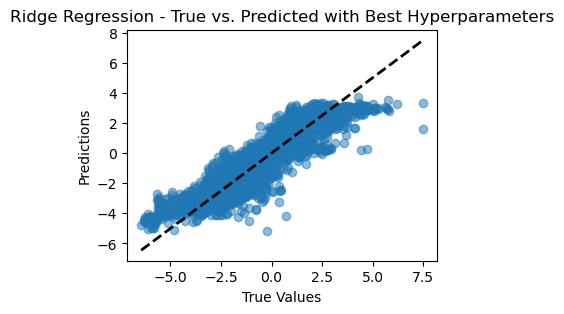

Elastic Regression Mean Absolute Error with Best Hyperparameters: 0.7299619104929477


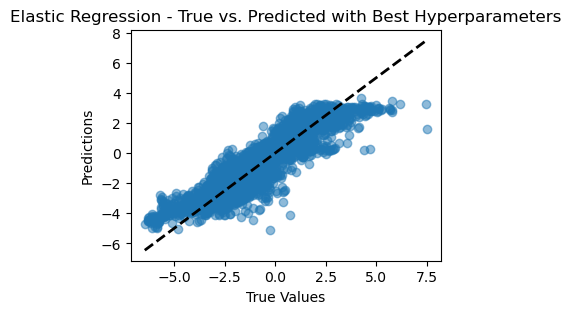

Kernel Ridge Regression Mean Absolute Error with Best Hyperparameters: 0.7355528398781098


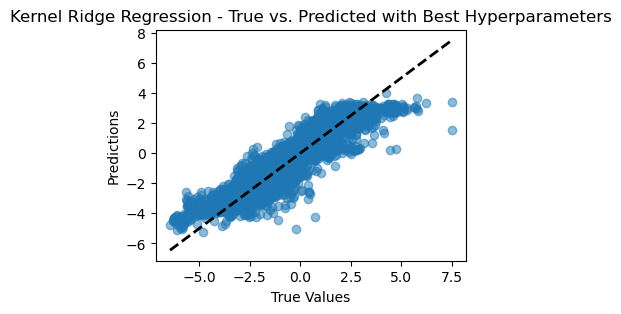

In [ ]:
# Tune hyperparameters and train models
for name, model_info in models.items():
    grid_search = GridSearchCV(model_info['model'], model_info['params'], scoring='neg_mean_absolute_error', cv=5)
    grid_search.fit(X_train_siamese, y_train)
    
    # Use the best model for predictions
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_siamese)
    
    # Mean Absolute Error
    mae = mean_absolute_error(y_test, y_pred)
    print(f"{name} Mean Absolute Error with Best Hyperparameters: {mae}")
    
    # Plot true vs. predicted values
    plt.figure(figsize=(4, 3))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel("True Values")
    plt.ylabel("Predictions")
    plt.title(f"{name} - True vs. Predicted with Best Hyperparameters")
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.show()

In [ ]:
## do: (ocp) x (ridge, elastic, krr, svr) x (siamese)

In [ ]:
# Combine both lists of DataFrames
all_dfs = list_env_train_cat1 + list_env_train_ocp1

# Initialize empty lists for all feature data and target data
all_feature_data = []
all_target_data = []

# Iterate over the combined list of DataFrames and create comparison data
for dataframe in all_dfs:
    feature_data, target_data = create_comparison_data(dataframe)
    all_feature_data.extend(feature_data)
    all_target_data.extend(target_data)

# Convert lists to arrays
X = np.array(all_feature_data)
y = np.array(all_target_data)

print(X.shape, y.shape)

In [ ]:
# 1. Standardize the Data
scaler = StandardScaler().fit(X)
X_std = scaler.transform(X)

In [ ]:
# 2. Split the Data into `fp1` and `fp2`
fp1 = torch.tensor(X_std[:, :777], dtype=torch.float32)
fp2 = torch.tensor(X_std[:, 777:], dtype=torch.float32)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(1)  # Convert y to tensor and add a dimension

In [ ]:
# Create DataLoader for batch processing
dataset = TensorDataset(fp1, fp2, y_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [ ]:
# 3. Define Hyperparameters for Grid Search
n_hidden_nodes = [8]
learning_rates = [0.01]
num_epochs = 100  # Adjust as necessary

In [ ]:
# 4. Train Siamese Network with Each Hyperparameter Combination

best_model = None
lowest_error = float('inf')

for n_hidden_node in n_hidden_nodes:
    for lr in learning_rates:
        
        model = SiameseNetwork(777, 17, n_hidden_node)
        optimizer = optim.Adam(model.parameters(), lr=lr)
        
        for epoch in range(num_epochs):
            print(epoch)
            for batch_fp1, batch_fp2, batch_y in dataloader:
                optimizer.zero_grad()
                outputs = model(batch_fp1, batch_fp2)
                loss = model.loss(outputs, batch_y)
                loss.backward()
                optimizer.step()
        
        # Calculate training error for the current hyperparameter combination
        with torch.no_grad():
            all_outputs = model(fp1, fp2)
            train_error = model.loss(all_outputs, y_tensor).item()
        
        # Update best model and lowest error if needed
        if train_error < lowest_error:
            lowest_error = train_error
            best_model = model

print(f"Best Model has a training error of: {lowest_error}")

In [ ]:
df_train_ocp1.shape, df_test_ocp1.shape

In [ ]:
df_train_ocp1.head(2)

In [ ]:
df_test_ocp1.head(2)

In [ ]:
# Separate features and targets
X_train = df_train_ocp1.iloc[:, 2:-1]
y_train = df_train_ocp1.iloc[:, -1]
X_test = df_test_ocp1.iloc[:, 2:-1]
y_test = df_test_ocp1.iloc[:, -1]

In [ ]:
# Standardize the features
scaler_X = StandardScaler().fit(X_train)
X_train_std = scaler_X.transform(X_train)
X_test_std = scaler_X.transform(X_test)

In [ ]:
X_train_tensor = torch.tensor(X_train_std, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_std, dtype=torch.float32)

In [ ]:
# Use the model to transform the data
X_train_siamese_tensor = best_model.nn_reg(X_train_tensor)
X_test_siamese_tensor = best_model.nn_reg(X_test_tensor)

In [ ]:
# Convert the output tensors to NumPy arrays
X_train_siamese = X_train_siamese_tensor.detach().numpy()
X_test_siamese = X_test_siamese_tensor.detach().numpy()

In [ ]:
print(X_train_siamese.shape, X_test_siamese.shape)

In [ ]:
# Models and hyperparameters
models = {
    'Ridge Regression': {
        'model': Ridge(),
        'params': {
            'alpha': [0.1, 1, 10]
        }
    },
    'Elastic Regression': {
        'model': ElasticNet(),
        'params': {
            'alpha': [0.1, 1, 10],
            'l1_ratio': [0.3, 0.5, 0.7]
        }
    },
    'Kernel Ridge Regression': {
        'model': KernelRidge(),
        'params': {
            'alpha': [0.1, 1, 10],
            'kernel': ['linear', 'polynomial', 'rbf'],
            'degree': [2, 3, 4]
        }
    },
    'Support Vector Regression': {
        'model': SVR(),
        'params': {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf'],
            'gamma': ['auto', 'scale']
        }
    }
}

In [ ]:
# Display mean absolute value of the target
mean_absolute_target = y_test.abs().mean()
print(f"Mean Absolute Value of Target: {mean_absolute_target}")

In [ ]:
# Tune hyperparameters and train models
for name, model_info in models.items():
    grid_search = GridSearchCV(model_info['model'], model_info['params'], scoring='neg_mean_absolute_error', cv=5)
    grid_search.fit(X_train_siamese, y_train)
    
    # Use the best model for predictions
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_siamese)
    
    # Mean Absolute Error
    mae = mean_absolute_error(y_test, y_pred)
    print(f"{name} Mean Absolute Error with Best Hyperparameters: {mae}")
    
    # Plot true vs. predicted values
    plt.figure(figsize=(4, 3))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.xlabel("True Values")
    plt.ylabel("Predictions")
    plt.title(f"{name} - True vs. Predicted with Best Hyperparameters")
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
    plt.show()